In [1]:
# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("A20-monthly_milk_production.csv")
df

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727
...,...,...
163,1975-08,858
164,1975-09,817
165,1975-10,827
166,1975-11,797


In [3]:
 df.shape

(168, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [5]:
# Check missing values
df.isnull().sum()

Date          0
Production    0
dtype: int64

In [6]:
df['Date'] = pd.to_datetime(df['Date']) # Convert Date column to datetime
df.set_index('Date', inplace=True)      # Set Date as index
df

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


In [7]:
# Exploratory Data Analysis (EDA)

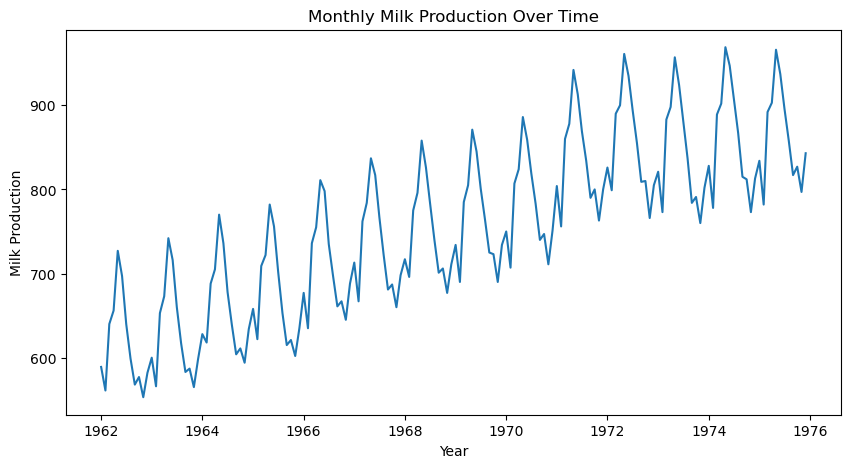

In [8]:
# Plot overall milk production trend

plt.figure(figsize=(10,5))
plt.plot(df['Production'])
plt.title("Monthly Milk Production Over Time")
plt.xlabel("Year")
plt.ylabel("Milk Production")
plt.show()


In [9]:
# Extract year and month 
df['Year'] = df.index.year 
df['Month'] = df.index.month

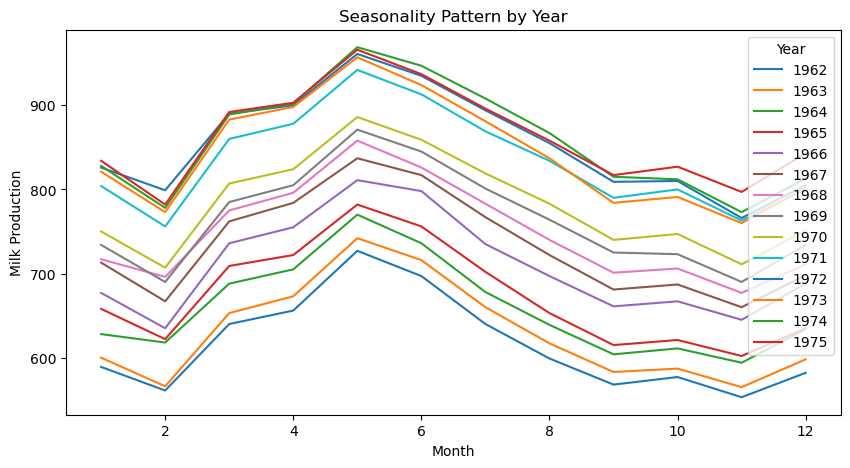

In [10]:
# Seasonal pattern across years
plt.figure(figsize=(10,5))
sns.lineplot(data=df,x="Month", y="Production", hue="Year", palette="tab10")
plt.title("Seasonality Pattern by Year")
plt.xlabel("Month")
plt.ylabel("Milk Production")
plt.show()

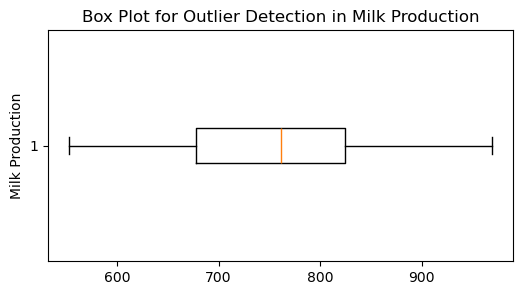

In [11]:
# Box plot to check for outliers
plt.figure(figsize=(6,3))
plt.boxplot(df['Production'], vert=False)
plt.title("Box Plot for Outlier Detection in Milk Production")
plt.ylabel("Milk Production")
plt.show()


In [12]:
# Data Scaling
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()
df["Scaled_Production"] = mm.fit_transform(df[["Production"]])

Data = pd.DataFrame(
    df["Scaled_Production"],
    index=df.index,
    columns=["Scaled_Production"]
)

Data.head()


,Scaled_Production
Date,
1962-01-01,0.086538
1962-02-01,0.019231
1962-03-01,0.209135
1962-04-01,0.247596
1962-05-01,0.418269


In [13]:
# This function converts time series into supervised learning format
def create_sequences(data, window_size=12):
    x, y = [], []
    for i in range(len(data) - window_size):
        x.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(x), np.array(y)

# Convert data into sequences
series = Data.values
x, y = create_sequences(series, window_size=12)

print("x shape:", x.shape)
print("y shape:", y.shape)


x shape: (156, 12, 1)
y shape: (156, 1)


In [14]:
# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

rnn_model = Sequential()
rnn_model.add(
    SimpleRNN(
        units=50,
        activation='tanh',
        input_shape=(x_train.shape[1], x_train.shape[2])
    )
)
rnn_model.add(Dense(1))  # Output layer
rnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
)

rnn_model.summary()

# Train RNN model
history_rnn = rnn_model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(x_test, y_test),
    verbose=1
)
# Make predictions using RNN
rnn_pred = rnn_model.predict(x_test)

# Evaluate RNN performance
rnn_rmse = np.sqrt(mean_squared_error(y_test, rnn_pred))
rnn_mae = mean_absolute_error(y_test, rnn_pred)
print("RNN RMSE:", rnn_rmse)
print("RNN MAE :", rnn_mae)



/opt/anaconda3/envs/anaconda-2025.04-py3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0231 - val_loss: 0.0283
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103 - val_loss: 0.0119
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0060
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0079
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - val_loss: 0.0058
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 13/50


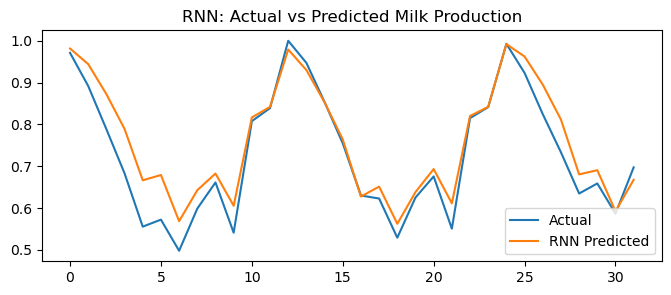

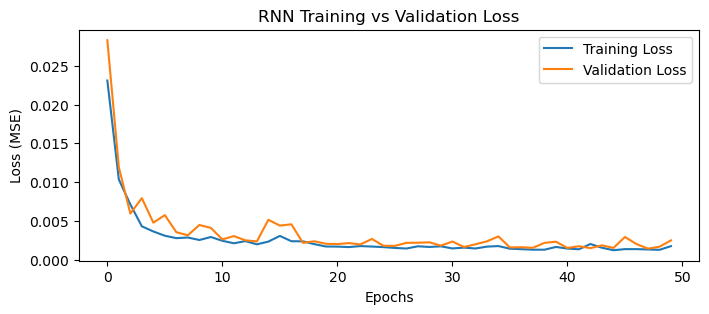

In [16]:
# Plot actual vs predicted values (RNN)
plt.figure(figsize=(8,3))
plt.plot(y_test, label="Actual")
plt.plot(rnn_pred, label="RNN Predicted")
plt.title("RNN: Actual vs Predicted Milk Production")
plt.legend()
plt.show()

# Training vs Validation Loss (RNN)
plt.figure(figsize=(8,3))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title("RNN Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()



In [17]:
"""
Both training and validation losses gradually decreased, indicating that 
the model learned in a stable manner without overfitting. However, due to the
limited memory of standard RNNs, the model may struggle to 
capture long-term dependencies present in the data.

"""

'\nBoth training and validation losses gradually decreased, indicating that \nthe model learned in a stable manner without overfitting. However, due to the\nlimited memory of standard RNNs, the model may struggle to \ncapture long-term dependencies present in the data.\n\n'

In [18]:
# Build and Train LSTM Model  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

lstm_model = Sequential()
lstm_model.add(
    LSTM(
        units=50,
        activation='tanh',
        input_shape=(x_train.shape[1], x_train.shape[2])
    )
)
lstm_model.add(Dense(1))
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

lstm_model.summary()

# Train LSTM model
history_lstm = lstm_model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(x_test, y_test),
    verbose=1
)

# Make predictions using LSTM
lstm_pred = lstm_model.predict(x_test)

# Evaluate LSTM performance
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
lstm_mae = mean_absolute_error(y_test, lstm_pred)
print("LSTM RMSE:", lstm_rmse)
print("LSTM MAE :", lstm_mae)

/opt/anaconda3/envs/anaconda-2025.04-py3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2455 - val_loss: 0.2866
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0769 - val_loss: 0.0429
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0305 - val_loss: 0.0372
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0327 - val_loss: 0.0298
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0273 - val_loss: 0.0401
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0274 - val_loss: 0.0320
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0263 - val_loss: 0.0264
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0257 - val_loss: 0.0269
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0255 - val_loss: 0.0303
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - val_loss: 0.0268
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 - val_loss: 0.0258
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243 - val_loss: 0.0251
Epoch 13/50


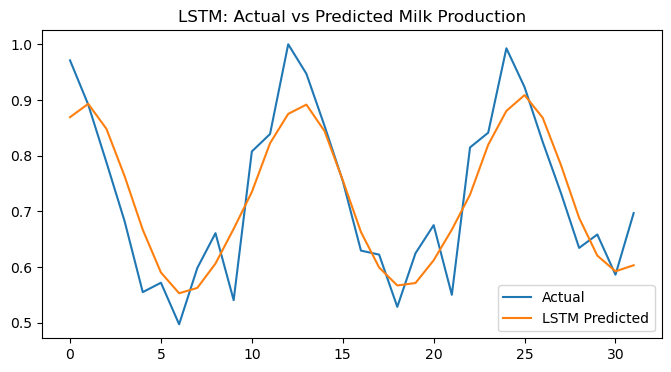

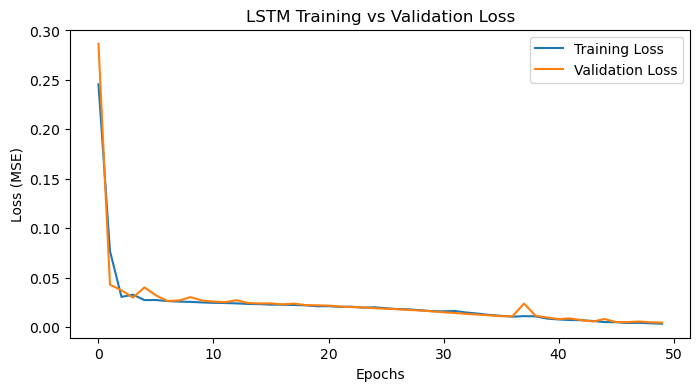

In [19]:
# Actual vs predicted values (LSTM)
plt.figure(figsize=(8,4))
plt.plot(y_test, label="Actual")
plt.plot(lstm_pred, label="LSTM Predicted")
plt.title("LSTM: Actual vs Predicted Milk Production")
plt.legend()
plt.show()

# Training vs validation loss (LSTM)
plt.figure(figsize=(8,4))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()




In [20]:
"""

The training and validation losses decreased steadily, indicating good model performance. 
The predicted values closely match the actual values, showing that LSTM handles long-term patterns better.

"""

'\n\nThe training and validation losses decreased steadily, indicating good model performance. \nThe predicted values closely match the actual values, showing that LSTM handles long-term patterns better.\n\n'

In [21]:
# Inverse scaling
y_test_inv = mm.inverse_transform(y_test)
rnn_pred_inv = mm.inverse_transform(rnn_pred)
lstm_pred_inv = mm.inverse_transform(lstm_pred)


In [22]:
# comparison
results = pd.DataFrame({
    "Model": ["RNN", "LSTM"],
    "RMSE": [rnn_rmse, lstm_rmse],
    "MAE": [rnn_mae, lstm_mae]
})

results


,Model,RMSE,MAE
0,RNN,0.050038,0.037306
1,LSTM,0.066871,0.055465


In [23]:
"""

The RNN model was able to learn short-term patterns in the data, 
but it had difficulty capturing long-term trends. In contrast,
the LSTM model handled seasonality and long-term dependencies more effectively, 
leading to lower RMSE and MAE values. Therefore, LSTM is a better choice 
for forecasting time-series data with long-term patterns.

"""

'\n\nThe RNN model was able to learn short-term patterns in the data, \nbut it had difficulty capturing long-term trends. In contrast,\nthe LSTM model handled seasonality and long-term dependencies more effectively, \nleading to lower RMSE and MAE values. Therefore, LSTM is a better choice \nfor forecasting time-series data with long-term patterns.\n\n'